<a href="https://colab.research.google.com/github/daeun118/MachineLearning1/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D1_1%EC%B0%A8%ED%8C%80%ED%94%8C_%EC%A0%95%EB%A6%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.load("/content/drive/MyDrive/ml1/train.npy", allow_pickle=True)
data = data.item()
data_input = data['input']

In [ ]:
labels = data['label']

In [ ]:
data_input

array([[[[-2.8890e+00],
         [-7.9550e+00],
         [-1.6170e+00],
         ...,
         [ 1.9430e+00],
         [-3.0920e+00],
         [-1.7090e+00]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.6170e+00],
         ...,
         [ 2.9200e+00],
         [-3.0920e+00],
         [ 2.4400e-01]],

        [[-3.3770e+00],
         [-8.9310e+00],
         [-1.5300e-01],
         ...,
         [ 3.4080e+00],
         [-3.0920e+00],
         [ 2.1970e+00]],

        ...,

        [[ 5.9000e+00],
         [ 3.7640e+00],
         [-8.9420e+00],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-1.9775e+01]],

        [[ 5.4120e+00],
         [ 3.2760e+00],
         [-1.0895e+01],
         ...,
         [-1.0000e-02],
         [ 5.2080e+00],
         [-2.1240e+01]],

        [[ 5.9000e+00],
         [ 2.7870e+00],
         [-1.1383e+01],
         ...,
         [-1.0000e-02],
         [ 5.6970e+00],
         [-2.2217e+01]]],


       [[[-3.8660e+00],


In [ ]:
labels.shape

(1080,)

In [ ]:
# 미리 스플릿
X_train, X_test, y_train, y_test = train_test_split(data_input,labels , test_size=0.2, random_state=156)

In [ ]:
print("X_train.shape:", X_train.shape)
print("X_valid.shape:", X_test.shape)

X_train.shape: (864, 256, 64, 1)
X_valid.shape: (216, 256, 64, 1)


# 전처리

In [ ]:
y_test.mean()

0.5

In [ ]:
y_train.shape

(864,)

In [ ]:
# X_train reshape

X_train_1 = []
for i in range(864):
    data_input_m = X_train[i][:][:].squeeze().T
    X_train_1.append(data_input_m)

input_T_train = np.array(X_train_1)
input_T_train.shape

(864, 64, 256)

In [ ]:
# X_valid reshape

X_test_1 = []
for i in range(216):
    data_input_m = X_test[i][:][:].squeeze().T
    X_test_1.append(data_input_m)

input_T_test = np.array(X_test_1)
input_T_test.shape

(216, 64, 256)

In [ ]:
data_input_train = input_T_train.reshape(864*64,256)
data_input_test= input_T_test.reshape(216*64,256)

print("data_input_train shape:", data_input_train.shape)
print("data_input_test shape:", data_input_test.shape)

data_input_train shape: (55296, 256)
data_input_test shape: (13824, 256)


In [ ]:
# train label 확장

repeated_arr_train = []
for i in range(len(y_train)):
    repeated_arr_train.extend(np.full(64, y_train[i]))

labels_train = np.array(repeated_arr_train)
labels_train.shape


(55296,)

In [ ]:
# valid label 확장

repeated_arr_test = []
for i in range(len(y_test)):
    repeated_arr_test.extend(np.full(64, y_test[i]))

labels_test = np.array(repeated_arr_test)
labels_test.shape

(13824,)

In [ ]:
print("labels_train.mean():", labels_train.mean())
print("labels_test.mean():", labels_test.mean())

labels_train.mean(): 0.5
labels_test.mean(): 0.5


## 노치 필터

In [ ]:
# 노치 필터

import numpy as np
from scipy.signal import iirnotch, filtfilt

def apply_notch_filter(data, notch_freq, fs, quality_factor=30):
    """
    주어진 데이터에 노치 필터를 적용하여 특정 주파수의 잡음을 제거합니다.

    :param data: 필터링할 데이터 (numpy 배열)
    :param notch_freq: 제거할 잡음의 주파수 (Hz)
    :param fs: 샘플링 주파수 (Hz)
    :param quality_factor: 노치 필터의 품질 계수 (높을수록 필터의 반응이 좁아집니다)
    :return: 필터링된 데이터
    """
    b, a = iirnotch(notch_freq, quality_factor, fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [ ]:
# 샘플링 주파수 설정
fs = 256

# 노치 필터 적용
# 특정 주파수의 전력선 잡음 필터링 - 국가에 따라 주로 50 또는 60 헤르츠

notch_band_train = apply_notch_filter(data_input_train, 60, fs)
notch_band_test = apply_notch_filter(data_input_test, 60, fs)

# notch_band_train = apply_notch_filter(notch_band_train, 60, fs)
# notch_band_valid = apply_notch_filter(notch_band_test, 60, fs)

## FFT 변환

In [ ]:
def fft(eeg_signal, sampling_rate):
    """
    주어진 EEG 신호에 대한 FFT를 계산하고 주파수 및 해당 주파수 성분의 파워를 시각화합니다.

    :param eeg_signal: EEG 신호 (1차원 numpy 배열)
    :param sampling_rate: 샘플링 주파수 (Hz)
    """
    n = len(eeg_signal)
    T = 1 / sampling_rate
    yf = np.fft.fft(eeg_signal)
    xf = np.fft.fftfreq(n, T)[:n//2]
    yf = 2.0/n * np.abs(yf[:n//2])
    return yf

In [ ]:
# train 데이터에 FFT 적용

FFT_train = []

# 여기서 각 행은 전체 EEG 시그널을 나타내며, 이를 FFT 함수에 전달
for i in range(55296):
    FFT_train.append(fft(notch_band_train[i], 500))  # 각 행 전체를 fft 함수에 전달

In [ ]:
# valid 데이터에 FFT 적용

FFT_test = []

# 따라서, 216 * 64 = 13824 개의 행이 각각 하나의 채널 데이터를 나타냅니다.
for i in range(13824):
    FFT_test.append(fft(notch_band_test[i], 500))

In [ ]:
# 리스트 -> numpy array

FFT_train = np.array(FFT_train)
FFT_test = np.array(FFT_test)

In [ ]:
print("FFT_train shape:", FFT_train.shape)
print("FFT_valid shape:", FFT_test.shape)

FFT_train shape: (55296, 128)
FFT_valid shape: (13824, 128)


## band power

In [ ]:
# band power 함수 정의

def enhanced_band_power(fft_data, sampling_rate):
    """
    주파수 대역을 0.5Hz 간격으로 세분화하여 각 세그먼트의 평균 파워를 계산합니다.

    :param fft_data: FFT 결과 (numpy 배열, 각 행이 하나의 채널의 FFT 결과)
    :param sampling_rate: 샘플링 주파수 (Hz)
    :return: 각 주파수 대역의 평균 파워를 포함하는 numpy 배열
    """
    freqs = np.fft.fftfreq(fft_data.shape[1] * 2, 1 / sampling_rate)[:fft_data.shape[1]]
    max_freq = sampling_rate / 2
    num_bands = int(max_freq / 1)  # 0.5Hz 간격으로 분할

    # 주파수 대역 정의
    band_indices = [np.logical_and(freqs >= i*0.5, freqs < (i+1)*0.5) for i in range(num_bands)]

    # 각 대역의 평균 파워 계산
    band_powers = np.zeros((fft_data.shape[0], num_bands))
    for i, idx in enumerate(band_indices):
        if np.any(idx):
            band_powers[:, i] = np.nanmean(fft_data[:, idx], axis=1)
        else:
            band_powers[:, i] = 0  # 데이터가 없는 경우 0 할당

    return band_powers

In [ ]:
# FFT_train과 FFT_valid에 band_power 함수 적용
band_power_train = np.vstack([enhanced_band_power(FFT_train[i * 64:(i + 1) * 64], 500) for i in range(864)])
band_power_test = np.vstack([enhanced_band_power(FFT_test[i * 64:(i + 1) * 64], 500) for i in range(216)])

print("band_power_train shape:", band_power_train.shape)
print("band_power_valid shape:", band_power_test.shape)


band_power_train shape: (55296, 250)
band_power_valid shape: (13824, 250)


In [ ]:
from sklearn.preprocessing import StandardScaler

# 스케일링
scaler = StandardScaler()
band_power_train = scaler.fit_transform(band_power_train)
band_power_test = scaler.transform(band_power_test)

# 모델링

In [ ]:
# XGBoost


from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 모델 초기화
XG_model = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1,
                         subsample=0.5, colsample_bytree=1, gamma=1.5, reg_lambda=5,
                         reg_alpha=5, min_child_weight=8, random_state=0)

XG_model.fit(band_power_train, labels_train, early_stopping_rounds=50,
              eval_metric="logloss", eval_set=[(band_power_test, labels_test)], verbose=True)

# 예측
y_test_pred_xg = XG_model.predict(band_power_test)
y_train_pred_xg = XG_model.predict(band_power_train) # train 정확도 확인용

# accuracy 확인(train/val)
train_accuracy_xg = accuracy_score(labels_train, y_train_pred_xg)
test_accuracy_xg = accuracy_score(labels_test, y_test_pred_xg)

print("XGBoost train Accuracy:", train_accuracy_xg)
print("XGBoost Validation Accuracy:", test_accuracy_xg)

# y_valid_pred_xg.mean()
print()
print("XGBoost y_valid_pred_xg.mean():", y_test_pred_xg.mean())

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68288
[1]	validation_0-logloss:0.67370
[2]	validation_0-logloss:0.66544
[3]	validation_0-logloss:0.65933
[4]	validation_0-logloss:0.65357
[5]	validation_0-logloss:0.64775
[6]	validation_0-logloss:0.64311
[7]	validation_0-logloss:0.63845
[8]	validation_0-logloss:0.63467
[9]	validation_0-logloss:0.63026
[10]	validation_0-logloss:0.62705
[11]	validation_0-logloss:0.62431
[12]	validation_0-logloss:0.62193
[13]	validation_0-logloss:0.61951
[14]	validation_0-logloss:0.61708
[15]	validation_0-logloss:0.61466
[16]	validation_0-logloss:0.61269
[17]	validation_0-logloss:0.61092
[18]	validation_0-logloss:0.60880
[19]	validation_0-logloss:0.60715
[20]	validation_0-logloss:0.60566
[21]	validation_0-logloss:0.60414
[22]	validation_0-logloss:0.60204
[23]	validation_0-logloss:0.60086
[24]	validation_0-logloss:0.59945
[25]	validation_0-logloss:0.59807
[26]	validation_0-logloss:0.59712
[27]	validation_0-logloss:0.59572
[28]	validation_0-logloss:0.59426
[29]	validation_0-loglos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 혼동행렬

In [ ]:

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels_test, y_test_pred_xg)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[4896 2016]
 [1900 5012]]


In [ ]:
t=0
acc = []
tt = []
while(t<=1):

    answer = []

    for i in range(216):
        pred = []
        for s in range(64):
            pred.append(y_test_pred_xg[i*64+s])
        if sum(pred)/len(pred) >=t:
            answer.append(1)
        else:
            answer.append(0)
    print(accuracy_score(y_test, answer), t)
    tt.append(t)
    acc.append(accuracy_score(y_test, answer))
    t+=0.001

0.5 0
0.5 0.001
0.5 0.002
0.5 0.003
0.5 0.004
0.5 0.005
0.5 0.006
0.5 0.007
0.5 0.008
0.5 0.009000000000000001
0.5 0.010000000000000002
0.5 0.011000000000000003
0.5 0.012000000000000004
0.5 0.013000000000000005
0.5 0.014000000000000005
0.5 0.015000000000000006
0.5138888888888888 0.016000000000000007
0.5138888888888888 0.017000000000000008
0.5138888888888888 0.01800000000000001
0.5138888888888888 0.01900000000000001
0.5138888888888888 0.02000000000000001
0.5138888888888888 0.02100000000000001
0.5138888888888888 0.022000000000000013
0.5138888888888888 0.023000000000000013
0.5138888888888888 0.024000000000000014
0.5138888888888888 0.025000000000000015
0.5138888888888888 0.026000000000000016
0.5138888888888888 0.027000000000000017
0.5138888888888888 0.028000000000000018
0.5138888888888888 0.02900000000000002
0.5138888888888888 0.03000000000000002
0.5138888888888888 0.03100000000000002
0.5185185185185185 0.03200000000000002
0.5185185185185185 0.03300000000000002
0.5185185185185185 0.0340000

## ROC 커브

ROC AUC: 0.7892319897728857


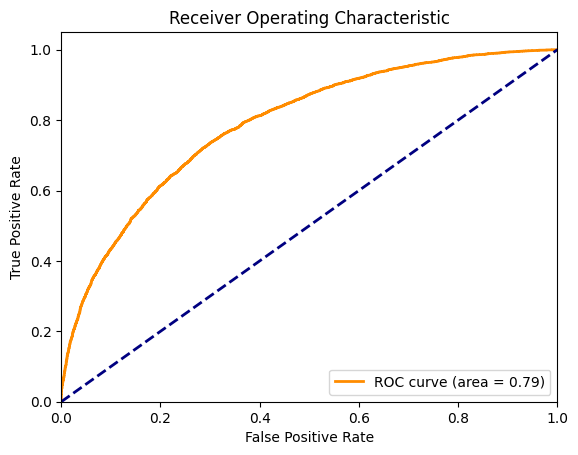

In [ ]:

fpr, tpr, thresholds = roc_curve(labels_test, XG_model.predict_proba(band_power_test)[:, 1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

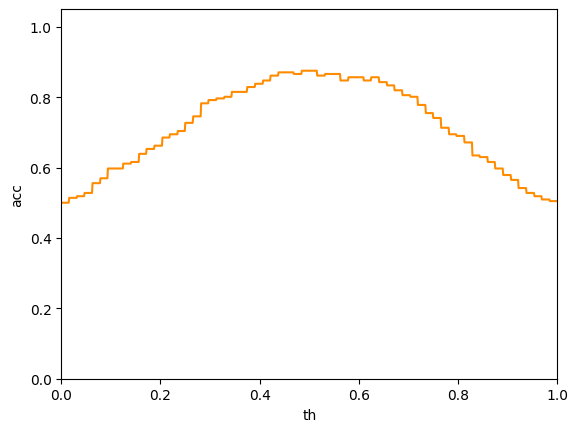

In [ ]:
plt.figure()
lw = 2
plt.plot(tt, acc, color='darkorange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('th')
plt.ylabel('acc')
plt.show()

In [ ]:

answer = []

for i in range(216):
    pred = []
    for s in range(64):
        pred.append(y_test_pred_xg[i*64+s])
    if sum(pred)/len(pred) >=0.45:
        answer.append(1)
    else:
        answer.append(0)
print(accuracy_score(y_test, answer))

0.8703703703703703


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, answer)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 84  24]
 [  4 104]]


# Test Data에 적용

In [ ]:
# test 파일 로드
data_test = np.load("/content/drive/MyDrive/ml1/test.npy", allow_pickle=True)
data_test = data_test.item()
data_input_test = data_test['input']

In [ ]:
# 전치

input_T_test = []
for i in range(120):
    data_input_m = data_input_test[i][:][:].squeeze().T
    input_T_test.append(data_input_m)

input_T_test = np.array(input_T_test)
input_T_test.shape

(120, 64, 256)

In [ ]:
data_input_test = input_T_test.reshape(120*64,256)
data_input_test.shape

(7680, 256)

In [ ]:
# 샘플링 주파수 설정 (예: 500 Hz)
fs = 256

# 노치 필터 적용
notch_band_test = apply_notch_filter(data_input_test, 60, fs)


In [ ]:
FFT_test = []

for i in range(7680):
    FFT_test.append(fft(data_input_test[i], 500))

In [ ]:
# 리스트 -> numpy array

FFT_test = np.array(FFT_test)

In [ ]:
# FFT_test에 band_power 함수 적용
band_power_test_test = np.vstack([enhanced_band_power(FFT_test[i * 64:(i + 1) * 64], 500) for i in range(120)])

print("band_power_test shape:", band_power_test_test.shape)

band_power_test shape: (7680, 250)


In [ ]:
band_power_test_test = scaler.transform(band_power_test_test)

In [ ]:
# predict

y_test_pred_xg_test = XG_model.predict(band_power_test_test)
print("y_test_pred_xg mean:", y_test_pred_xg.mean())

y_test_pred_xg mean: 0.5083912037037037


In [ ]:
csv = list(y_test_pred_xg_test)
len(csv)

7680

In [ ]:
# 64개씩 1그룹. 다수결로 라벨 결정

answer = []

for i in range(120):
    pred = []
    for s in range(64):
        pred.append(csv[i*64+s])
    if sum(pred)/len(pred) > 0.56:
        answer.append(1)
    else:
        answer.append(0)

len(answer)

120

In [ ]:
test_pred = np.array(answer)
test_pred.mean()

0.5416666666666666

In [ ]:
# 제출하기

id=np.arange(120)
target=answer

submission_df=pd.DataFrame({'ID':id, 'Target':target})

submission_df

,ID,Target
0,0,1
1,1,1
2,2,0
3,3,1
4,4,1
...,...,...
115,115,0
116,116,1
117,117,0
118,118,0


In [ ]:
submission_df.mean()

ID        59.500000
Target     0.541667
dtype: float64

In [ ]:
# csv 파일로 내보내기

submission_df.to_csv('submission_05129.csv',index = False)